# Essais et développement de la méthode de calage sur marges

In [ ]:
# | hide
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from leximpact_common_python_libraries.config import Configuration

config = Configuration(project_folder="leximpact-prepare-data")

In [ ]:
import unittest

tc = unittest.TestCase()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-01-17 21:41:55.542925: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-17 21:41:55.542951: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# CALMAR

## Échantillon de données pour test

In [ ]:
# Une première étape sera de mettre la base sous format Y=f(X) avec X le RFR et Y nos données d'intérêt

In [ ]:
# On initialise nos données:
# sample=erfs, X=RFR, d=wprm nos poids de sondage et Y notre variable d'intéret

sample = pd.DataFrame(
    [
        [1, 1, 0, 12],  # Bucket 0
        [2, 1, 0, 32],
        [3, 1, 0, 5],
        [4, 1, 46, 0],  # Bucket 0-100
        [5, 1, 99, 4323],
        [6, 1, 90, 104],
        [7, 1, 250, 102],  # Bucket 250-1000
        [8, 1, 300, 1253],
        [9, 1, 1000, 92],
        [10, 1, 21_000, 9217],  # Bucket 1000-25000
        [11, 1, 12_000, 91],
        [12, 1, 1000, 0],
        [13, 1, 8000, 0],
        [14, 1, 1830, 9812],
        [15, 1, 1185, 100281],
        [16, 1, 1981, 9822],
        [17, 1, 18417, 91],
        [18, 1, 26_000, 2301],  # Bucket 25000-50000
        [19, 1, 49_000, 87203],
    ],
    columns=["idfoy", "d", "X", "Y"],
)

sample.head()

idfoy  d   X     Y
0      1  1   0    12
1      2  1   0    32
2      3  1   0     5
3      4  1  46     0
4      5  1  99  4323

In [ ]:
estimateur_y = (sample["d"] * sample["Y"]).sum()
print(estimateur_y)

224741


# Neural Network

## Échantillon de données pour test

In [ ]:
# Import de la base ERFS et sélection d'un échantillon
erfs_03 = pd.read_hdf(
    config.get("DATA_OUT") + "03_erfs_rfr_cal_ind" + config.get("YEAR_ERFS") + ".h5"
)
erfs_03.columns
erfs_03.tail()

Index(['activite', 'age', 'categorie_salarie', 'chomage_brut',
       'contrat_de_travail', 'date_naissance', 'effectif_entreprise',
       'heures_remunerees_volume', 'idfam', 'idfoy', 'idmen', 'noindiv',
       'pensions_alimentaires_percues', 'quifam', 'quifoy', 'quimen', 'rag',
       'retraite_brute', 'ric', 'rnc', 'statut_marital', 'salaire_de_base',
       'idmen_original', 'idfoy_original', 'idfam_original', 'idmen_x', 'wprm',
       'zone_apl', 'fake_id', 'f4ba', 'quimenof', 'quifoyof', 'quifamof',
       'rfr'],
      dtype='object')

activite  age  categorie_salarie  chomage_brut  contrat_de_travail  \
337803       0.0   51                  1             0                   0   
337804       0.0   44                  1             0                   0   
337805       0.0   80                  1             0                   0   
337806       0.0   66                  0             0                   1   
337807       0.0   62                  0             0                   0   

       date_naissance  effectif_entreprise  heures_remunerees_volume   idfam  \
337803     1966-01-14                   50                       0.0  172206   
337804     1973-01-14                  500                       0.0  172207   
337805     1937-10-04                   50                       0.0  172208   
337806     1951-01-04                    0                    1144.0  172209   
337807     1955-04-17                  500                       0.0  172210   

         idfoy  ...  idfam_original   idmen_x      wprm  zone_apl  fake_id  \
337803  172206  ...      1802957401  18011370  0.668483         2      1.0   
337804  172207  ...      1801891601  18028481  0.989284         2      1.0   
337805  172208  ...      1803209401  18019488  0.693574         2      1.0   
337806  172209  ...      1804042701  18011185  0.885337         2      1.0   
337807  172210  ...      1803086002  18038170  0.793936         2      1.0   

            f4ba               quimenof             quifoyof   quifamof  \
337803    4399.0  personne_de_reference  declarant_principal  demandeur   
337804    1500.0  personne_de_reference  declarant_principal  demandeur   
337805       0.0  personne_de_reference  declarant_principal  demandeur   
337806  139340.0  personne_de_reference  declarant_principal  demandeur   
337807       0.0  personne_de_reference  declarant_principal  demandeur   

                 rfr  
337803  3.186688e+07  
337804  4.977271e+07  
337805  9.158978e+07  
337806  6.888963e+07  
337807  5.150487e+07  

[5 rows x 34 columns]

In [ ]:
# Notre échantillon pour tests
dataset = erfs_03[
    [
        "idfoy",
        "quifoy",
        "wprm",
        "salaire_de_base",
        "chomage_brut",
        "retraite_brute",
        "f4ba",
        "rfr",
    ]
]

# Pour tester sur une partie de la base
dataset = erfs_03.sample(n=1000, random_state=53)
print("On a ", len(dataset), "individus dans cet échantillon")

dataset.head()

# Ici, wprm sont les poids initiaux dits "de sondage"

On a  337808 individus dans cet échantillon


idfoy  quifoy        wprm  salaire_de_base  chomage_brut  retraite_brute  \
0      0       0  272.745914         0.000000             0            3560   
1      1       0  227.157260         0.000000             0           19360   
2      1       1  227.157260         0.000000             0           28230   
3      2       0  194.930798     65283.748389             0               0   
4      2       1  194.930798     29200.808225             0               0   

    f4ba           rfr  
0    0.0    755.000244  
1    0.0  43778.000000  
2    0.0      0.000000  
3  550.0  70192.570312  
4    0.0      0.000000

In [ ]:
# Nos variables auxilliaires sont: le salaire_de_base, le chomage_brut, la retraite_brute et le f4ba (revenu foncier)
J = 4
X_avant = [
    (dataset["wprm"] * dataset["salaire_de_base"]).sum(),
    (dataset["wprm"] * dataset["chomage_brut"]).sum(),
    (dataset["wprm"] * dataset["retraite_brute"]).sum(),
    (dataset["wprm"] * dataset["f4ba"]).sum(),
]

X_avant

[787347859186.1661, 35973091573.96126, 425467165630.34125, 44012929315.33398]

In [ ]:
# Pour calibrer, on introduit les totaux "wanted"  ( TODO: à paramétriser)
X = [
    650855163531.0,  # Salaire imposable POTE 2019
    0.97
    * (
        dataset["wprm"] * dataset["chomage_brut"]
    ).sum(),  # On ne connait pas le chiffre, donc on met un ecart pour calibrer
    307,
    254,
    581,
    479.0,
    1.34
    * (
        dataset["wprm"] * dataset["f4ba"]
    ).sum(),  # On ne connait pas le chiffre, donc on met un ecart pour calibrer
]
X

KeyError: 'wprm'

In [ ]:
# On cherche Y_final le total estimé de RFR. Pour l'instant (avec les poids de sondage on a:)
Y_initial = (dataset["wprm"] * dataset["salaire_de_base"]).sum()

# On le comparera à
Y_wanted = 1084463009284.0  # RFR POTE 2019

# Soit l'erreur avant calibration:
error_initiale = 100 * abs((Y_initial - Y_wanted) / Y_wanted)
print("Erreur avant calibration: ", error_initiale, " %")

Erreur avant calibration:  27.39744440836203  %


## Préparation des données

Source: https://www.tensorflow.org/tutorials/keras/regression

In [ ]:
# On enlève les poids
poids_de_sondage = dataset.pop("wprm")
dataset

idfoy  quifoy  salaire_de_base  chomage_brut  retraite_brute  \
0            0       0         0.000000             0            3560   
1            1       0         0.000000             0           19360   
2            1       1         0.000000             0           28230   
3            2       0     65283.748389             0               0   
4            2       1     29200.808225             0               0   
...        ...     ...              ...           ...             ...   
337803  172206       0    103137.884440             0               0   
337804  172207       0    230051.282743             0               0   
337805  172208       0     75753.850777             0           44950   
337806  172209       0     94000.069794             0           89590   
337807  172210       0    207422.526941             0               0   

            f4ba           rfr  
0            0.0  7.550002e+02  
1            0.0  4.377800e+04  
2            0.0  0.000000e+00  
3          550.0  7.019257e+04  
4            0.0  0.000000e+00  
...          ...           ...  
337803    4399.0  3.186688e+07  
337804    1500.0  4.977271e+07  
337805       0.0  9.158978e+07  
337806  139340.0  6.888963e+07  
337807       0.0  5.150487e+07  

[337808 rows x 7 columns]

In [ ]:
poids_de_sondage.head()

0    272.745914
1    227.157260
2    227.157260
3    194.930798
4    194.930798
Name: wprm, dtype: float64

### Nettoyer les données

In [ ]:
# On vérifie qu'on n'a pas de Nans
tc.assertEqual(dataset.isna().sum().sum(), 0)

# Si c'est le cas, on pourra les enlever:
# dataset = dataset.fillna(0) ou dataset = dataset.dropna(0)

### Mapping des variables catégorielles

In [ ]:
# Déjà fait dans Survey Manager

# dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

### Training dataset VS Test dataset

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)  # Fixé pour le dev
test_dataset = dataset.drop(train_dataset.index)
train_dataset.head()
test_dataset.head()

### Inspecter les données

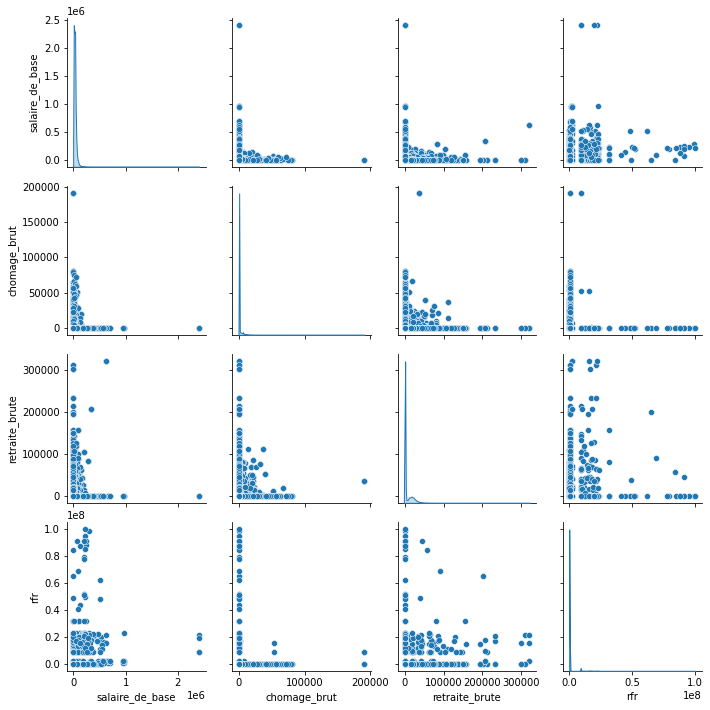

In [ ]:
# On utilise le KDE (Kernel Density Estimator) qui donne la distribution d'une single variable ( chom= f(chom)) en courbe plutôt qu'un histogramme
sns.pairplot(
    train_dataset[["salaire_de_base", "chomage_brut", "retraite_brute", "rfr"]],
    diag_kind="kde",
)

In [ ]:
train_dataset.describe().transpose()

count          mean            std  min       25%  \
idfoy            270246.0  85734.177205   49489.055170  0.0  42886.25   
quifoy           270246.0      0.729117       0.821988  0.0      0.00   
salaire_de_base  270246.0  10208.258504   24643.348758  0.0      0.00   
chomage_brut     270246.0    464.692539    2550.259738  0.0      0.00   
retraite_brute   270246.0   5513.533521   11321.682394  0.0      0.00   
f4ba             270246.0   1027.900231   35894.491765  0.0      0.00   
rfr              270246.0  35649.712161  857931.558593  0.0      0.00   

                     50%            75%           max  
idfoy            85680.5  128600.750000  1.722100e+05  
quifoy               0.0       1.000000  2.000000e+00  
salaire_de_base      0.0   14964.297000  2.404751e+06  
chomage_brut         0.0       0.000000  1.908200e+05  
retraite_brute       0.0    6700.000000  3.202300e+05  
f4ba                 0.0       0.000000  3.929577e+06  
rfr                  0.0   21366.865503  1.000843e+08

### Séparer la valeur cible

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# On met de côté la variable qu'on veut calculer
train_labels = train_features.pop("rfr")
test_labels = test_features.pop("rfr")

NOTES

- Quand on normalise ici, on va toucher aux Idfoy et Quifoy, qui devraient rester, respectivement, un nombre entier et un binaire
- Pour éviter cela, il me semble qu'il faudrait s'appliquer à ne calculer des variables sur une base foyer uniquement sur la table foyer (auquel cas on se passe de ces 2 colonnes), et des variables en individus sur la base individus

### Normalisation (feature scaling)

In [ ]:
# On observe les écarts entre les variables
train_dataset.describe().transpose()[["mean", "std"]]

mean            std
idfoy            85734.177205   49489.055170
quifoy               0.729117       0.821988
salaire_de_base  10208.258504   24643.348758
chomage_brut       464.692539    2550.259738
retraite_brute    5513.533521   11321.682394
f4ba              1027.900231   35894.491765
rfr              35649.712161  857931.558593

In [ ]:
# On crée le calque
normalizer = tf.keras.layers.Normalization(axis=-1)

# On l'adapte aux données (mean et std)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

2022-01-17 21:42:05.364910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-17 21:42:05.364949: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-17 21:42:05.364982: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-hub): /proc/driver/nvidia/version does not exist
2022-01-17 21:42:05.365174: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[85734.01      0.729 10208.252   464.692  5513.554  1027.902]]


In [ ]:
# On peut voir l'effet de la normalization sur notre première ligne:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print("First example:", first)
    print("Normalized:", normalizer(first).numpy())

First example: [[155024.        1.    47722.54      0.        0.        0.  ]]
Normalized: [[ 1.4   0.33  1.52 -0.18 -0.49 -0.03]]


## Régression linéaire

On commence par faire une régression linéaire à variable unique : RFR = f(salaire_de_base)

Pour cela on utilise un modèle séquentiel (tf.lera.Sequential) qui comporte 2 étapes:
- la normalisation (tf.keras.layers.Normalization)
- la régression linéaire (tf.keras.layers.Dense)

In [ ]:
# On se limite à 1 colonne
salaire = np.array(train_features["salaire_de_base"])

### 1 - On prépare le normalizer

In [ ]:
salaire_normalizer = layers.Normalization(
    input_shape=[
        1,
    ],
    axis=None,
)
salaire_normalizer.adapt(salaire)

### 2 - On construit un modèle séquentiel

In [ ]:
salaire_model = tf.keras.Sequential([salaire_normalizer, layers.Dense(units=1)])

salaire_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


### Prédictions

In [ ]:
salaire[:5]
salaire_model.predict(salaire[:5])

array([47722.535,     0.   , 21578.21 ,     0.   ,     0.   ])

array([[ 1.884],
       [-0.513],
       [ 0.571],
       [-0.513],
       [-0.513]], dtype=float32)

In [ ]:
# Configuring the training procedure [C'EST ICI QU'ON FAIT LES CHOIX DE METHODE DE CALIBRATION]
salaire_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),  # Méthode d'optimisation
    loss="mean_absolute_error",
)  # Ce qu'on cherche à optimizer

### Training

In [ ]:
%%time
# On entraine le modèle sur 100 epochs
history = salaire_model.fit(
    train_features["salaire_de_base"],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2,
)

CPU times: user 10min 17s, sys: 1min 8s, total: 11min 25s
Wall time: 6min 23s


In [ ]:
# Visualize the model's training progress using the stats stored in the history object:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

loss      val_loss  epoch
95  31708.880859  34078.207031     95
96  31708.953125  34078.210938     96
97  31708.863281  34078.218750     97
98  31708.919922  34078.222656     98
99  31709.003906  34078.222656     99

In [ ]:
# Fonction pour observer l'évolution du coût


def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    minimum = min(min(history.history["loss"]), min(history.history["val_loss"]))
    maximum = max(max(history.history["loss"]), max(history.history["val_loss"]))
    plt.ylim(minimum, maximum)
    plt.xlabel("Epoch")
    plt.ylabel("Error [RFR]")
    plt.legend()
    plt.grid(True)

31708.8203125

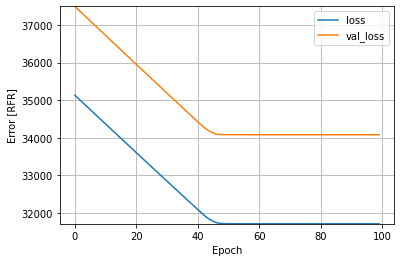

In [ ]:
min(history.history["loss"])
plot_loss(history)

In [ ]:
# Collect the results on the test set for later
test_results = {}

test_results["salaire_model"] = salaire_model.evaluate(
    test_features["salaire_de_base"], test_labels, verbose=0
)

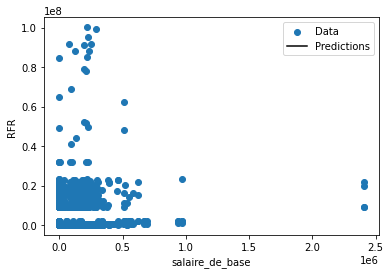

In [ ]:
# Vu que c'est une régression simple, on peut même plotter la prédiction:
x = tf.linspace(0.0, 250, 251)
y = salaire_model.predict(x)


def plot_salaire(x, y):
    plt.scatter(train_features["salaire_de_base"], train_labels, label="Data")
    plt.plot(x, y, color="k", label="Predictions")
    plt.xlabel("salaire_de_base")
    plt.ylabel("RFR")
    plt.legend()


plot_salaire(x, y)

## Linear regression with multiple input
You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same  y = m.x + b except that m is a matrix and b is a vector.

Create a two-step Keras Sequential model again with the first layer being normalizer (tf.keras.layers.Normalization(axis=-1)) you defined earlier and adapted to the whole dataset:

In [ ]:
linear_model = tf.keras.Sequential([normalizer, layers.Dense(units=1)])

We call Model.predict on a batch of inputs, which produces units=1 outputs for each example:

In [ ]:
linear_model.predict(train_features[:10])

array([[ 0.272],
       [-0.274],
       [-0.166],
       [ 0.248],
       [-0.255],
       [ 0.165],
       [ 0.151],
       [ 0.285],
       [-0.179],
       [ 0.274]], dtype=float32)

In [ ]:
# La matrice des poids (on en a 7 par 1: un poids par colonne par personne)
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(6, 1) dtype=float32, numpy=
array([[0.347],
       [0.058],
       [0.006],
       [0.623],
       [0.211],
       [0.875]], dtype=float32)>

Configuring the model with Keras Model.compile and train with Model.fit for 100 epochs:

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mean_absolute_error"
)

In [ ]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2,
)

CPU times: user 10min 32s, sys: 1min 8s, total: 11min 41s
Wall time: 6min 25s


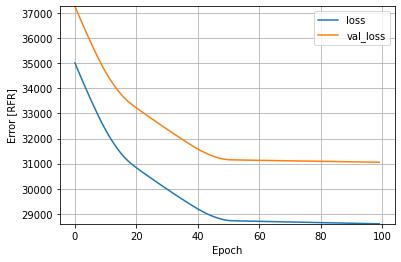

In [ ]:
plot_loss(history)

Collecting the results on the test set for later:

In [ ]:
test_results["linear_model"] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

## Utilisation d'un neural network

Source: https://www.tensorflow.org/tutorials/keras/regression

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

The normalization layer, as before (with horsepower_normalizer for a single-input model and normalizer for a multiple-input model).
Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.
A linear Dense single-output layer.
Both models will use the same training procedure so the compile method is included in the build_and_compile_model function below.

In [ ]:
def build_and_compile_model(norm):
    model = keras.Sequential(
        [
            norm,
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(1),
        ]
    )

    model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(0.001))
    return model

Regression using a DNN and a single input
Create a DNN model with only 'salaire_de_base' as input and salaire_normalizer (defined earlier) as the normalization layer:

In [ ]:
dnn_salaire_model = build_and_compile_model(salaire_normalizer)

In [ ]:
# This model has quite a few more trainable parameters than the linear models:

dnn_salaire_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [ ]:
%%time

# Training the model with Keras Model.fit:
history = dnn_salaire_model.fit(
    train_features["salaire_de_base"],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100,
)

CPU times: user 12min 29s, sys: 1min 37s, total: 14min 6s
Wall time: 7min 19s


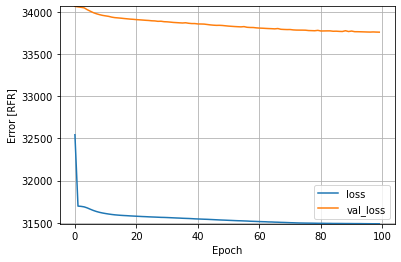

In [ ]:
plot_loss(history)

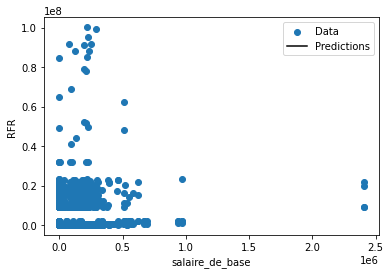

In [ ]:
# Fonction pour observer l'évolution du coût en fonction de la variable d'entree
x = tf.linspace(0.0, 250, 251)
y = dnn_salaire_model.predict(x)

plot_salaire(x, y)

In [ ]:
# Collecting the results on the test set for later:

test_results["dnn_salaire_model"] = dnn_salaire_model.evaluate(
    test_features["salaire_de_base"], test_labels, verbose=0
)

## Regression using a DNN and multiple inputs
Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [ ]:
# Repeating the previous process using all the inputs.
# The model's performance slightly improves on the validation dataset.

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                448       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    train_features, train_labels, validation_split=0.2, verbose=0, epochs=100
)

CPU times: user 12min 38s, sys: 1min 34s, total: 14min 13s
Wall time: 7min 20s


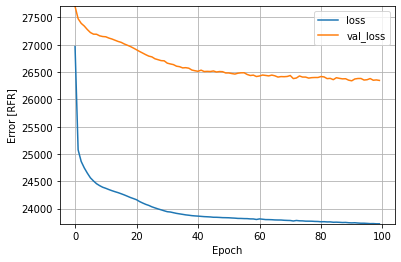

In [ ]:
plot_loss(history)

In [ ]:
test_results["dnn_model"] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance
Now that all models are trained, let's review their test set performance

In [ ]:
pd.DataFrame(test_results, index=["Mean absolute error [RFR]"]).T

Mean absolute error [RFR]
salaire_model                   34170.281250
linear_model                    31090.541016
dnn_salaire_model               33908.257812
dnn_model                       26228.125000

## Making predictions

Text(0.5, 0, 'True Values [RFR]')

Text(0, 0.5, 'Predictions [RFR]')

(0.0, 50.0)

(0.0, 50.0)

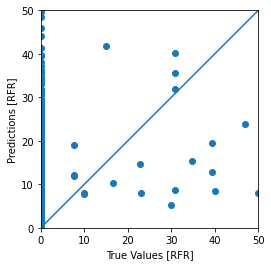

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect="equal")
plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [RFR]")
plt.ylabel("Predictions [RFR]")
maximum = max(max(test_labels), max(test_predictions))
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

(array([    2.,     0.,     0.,     0.,     1.,     1.,     0.,     0.,
            1.,     0.,     1.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,    10.,    20.,    16.,    25.,     4., 67468.,
           13.]),
 array([-96741090.784, -92674230.853, -88607370.921, -84540510.99 ,
        -80473651.059, -76406791.127, -72339931.196, -68273071.264,
        -64206211.333, -60139351.402, -56072491.47 , -52005631.539,
        -47938771.608, -43871911.676, -39805051.745, -35738191.814,
        -31671331.882, -27604471.951, -23537612.02 , -19470752.088,
        -15403892.157, -11337032.225,  -7270172.294,  -3203312.363,
           863547.569,   4930407.5  ]),
 <BarContainer object of 25 artists>)

Text(0.5, 0, 'Prediction Error [MPG]')

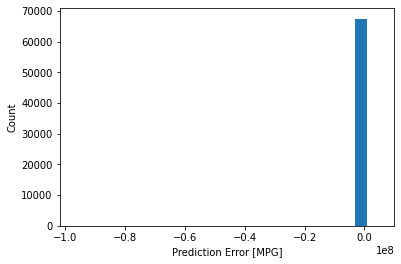

In [ ]:
# Checking the error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [RFR]")
_ = plt.ylabel("Count")

In [ ]:
# Saving the model for later
dnn_model.save("dnn_model")

2022-01-17 22:09:49.930273: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dnn_model/assets


In [ ]:
# We can reload the model and have the exact same results:
reloaded = tf.keras.models.load_model("dnn_model")

test_results["reloaded"] = reloaded.evaluate(test_features, test_labels, verbose=0)

## Conclusion

We can improve this method by:

- Choosing the loss function. Mean squared error (MSE) (tf.losses.MeanSquaredError) and mean absolute error (MAE) (tf.losses.MeanAbsoluteError) are commonly used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.

- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the Overfit and underfit tutorial for more help with this.

# Overfit and underfit
Source: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit